# Machine learning to predict new crescent moon visibility

## Imports

In [106]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #Issue with xgboost & new pandas version
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from astropy.time import Time
from enum import Enum
import shap
import cartopy.crs as ccrs

# MACHINE LEARNING IMPORTS
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, accuracy_score,precision_score,recall_score,f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier

In [107]:
class methods(Enum):
    XGBoost = 0
    RandomForest = 1
    DecisionTree = 2
    NearestNeighbours = 3
    NaiveBayes = 4
    AdaBoost = 5
    GaussianProcess = 6
    ExtraTrees = 7
    SupportVector = 8
    Logistic = 9
    NeuralNet = 10

class outputs(Enum):
    Binary = 0 #Naked eye seen or not seen
    MultiLabel = 1 #Replace naked eye seen column with either seen, visual aid or not seen
    MultiOutput = 2 #Replace naked eye seen column with array of methods

## Options and setup

In [108]:
CLOUDCUT = False # Only use clear data points
GRID_SEARCH = False # gridsearch for best hyperparameters
REPEAT_ACCURACY = False #Run 20 times and calculate average accuracy
USE_GPU = False #Use a GPU if available
SHAP_ANALYSIS = False #Run shap analysis of data
PREDICT_VISIBILITY = False #Predict visibility based on file with generated parameters
COMPARE_METHODS = False #Calculate accuracy for all available methods
WEATHER_DATA = False
DATA_FILE = '../Data/moon_sighting_data.csv' #File containing data

METHOD = methods.XGBoost #Select ML model to use
OUTPUT = outputs.Binary #Select output - binary eye visibility, seen/aid/not seen, or specific methods

#Drop index, dependent parameters (q value etc) and visibility scale. q' value is excluded automatically
#VARS_TO_DROP = ["Index","q","W","Source","Date"]
VARS_TO_DROP = ["Index","q","W","Source","Date","Sunset","Moonset"]
#VARS_TO_DROP = ["Index","q","W","Source","Date", "Longitude","Latitude","Sunset","Moonset"]
#VARS_TO_DROP = ["Index","q","W","Source","Date", "Longitude","Latitude","Sunset","Moonset","Sun Alt", "Sun Az", "Moon Alt", "Moon Az"]
#VARS_TO_DROP = ["Index","q","W","Source","Date", "Longitude","Latitude","Sunset","Moonset","ARCV", "DAZ"]

if WEATHER_DATA:
    DATA_FILE = '../Data/cloud_data_distance_cut.csv'
    VARS_TO_DROP = ["Index","q","W","Distance", "Cloud Level","Source","Visibility"]

TITLE = f"{METHOD.name} {OUTPUT.name} visibility"

## Hyperparameters

In [109]:
def set_params():
    if METHOD == methods.XGBoost:
        params = {'learning_rate': 0.55, 'max_depth': 3, 'n_estimators': 110}
        #params = {'learning_rate': 1, 'max_depth': 10, 'n_estimators': 300}
            
    elif METHOD == methods.RandomForest: #Random forest
        params = params = {'max_depth': 12, 'n_estimators': 150}
    else:
        params = {}
    params = {}
    return params

## Reading in data

In [110]:
data = pd.read_csv(DATA_FILE)

print(f"Loaded {data.shape[0]} rows")

if OUTPUT == outputs.MultiOutput:
    data = data.drop(["Seen", "Method"], axis = 1) # replaced by methods column

    ptype = ["Seen_eye", "Seen_binoculars", "Seen_telescope", "Seen_ccd","Not_seen"]

elif OUTPUT == outputs.MultiLabel:
    data = data.drop(["Seen", "Methods"], axis = 1) # replaced by method column
    data["Method"] = data["Method"].replace("Seen_binoculars", "Seen_with_aid")
    data["Method"] = data["Method"].replace("Seen_telescope", "Seen_with_aid")
    data["Method"] = data["Method"].replace("Seen_ccd", "Seen_with_aid")

    ptype = ["Seen_eye", "Seen_with_aid", "Not_seen"]


elif OUTPUT == outputs.Binary:
    data = data[data["Method"] !="Seen_binoculars"] #DROP BINOCULARS
    data = data[data["Method"] !="Seen_ccd"] #DROP CCD
    data = data[data["Method"] !="Seen_telescope"] #DROP TELESCOPE
    
    data=data.drop(['Method','Methods'], axis = 1) #Only use seen

    ptype = ["Seen", "Not_seen"]


if CLOUDCUT:
    #data = data[data["Cloud Level"] <= 0.5]
    data = data[data["Cloud Level"] == 0]

#Drop index, dependent parameters (q value etc) and visibility scale
data = data.drop(VARS_TO_DROP+["q'"], axis = 1)

# if PREDICT_VISIBILITY:
#     data = data.drop("Cloud Level", axis = 1) #Remove cloud level for future predictions

print(f"Using {data.shape[0]} rows")
#data.head(5)

Loaded 5302 rows
Using 4518 rows


## Visualising variables

In [111]:
# Visualising a couple of variables.
variable_list =  data.columns.tolist()
print(variable_list)

# Plot data
showpairplot = False
if showpairplot == True:
   fig = sns.pairplot(data[variable_list], hue = 'Seen', palette = 'bright')

   # Change location of legend
   fig._legend.set_bbox_to_anchor((1.05, 0.5))

   # Add legend
   for t, l in zip(fig._legend.texts, ptype):
      t.set_text(str(t.get_text()) + " - " + str(l))

   plt.show()

['Latitude', 'Longitude', 'Moon Age', 'Lag', 'Moon Alt', 'Moon Az', 'Sun Alt', 'Sun Az', 'Moon-Earth Dist', 'Sun-Moon Dist', 'ARCL', 'ARCV', 'DAZ', 'Illumination', 'Parallax', "W'", 'Cloud Level', 'Seen']


## Selecting a ML model

In [112]:
def select_model():
    if METHOD == methods.XGBoost:
        if OUTPUT == outputs.MultiOutput:
            if USE_GPU:
                method = "gpu_hist"
            else:
                method = "hist"
            model = XGBClassifier(tree_method=method, n_jobs=-1)
        else:
            model = XGBClassifier(n_jobs=-1)

    elif METHOD == methods.RandomForest:
        if OUTPUT == outputs.MultiOutput:
            model = MultiOutputClassifier(RandomForestClassifier(n_jobs=-1))
        else:
            model = RandomForestClassifier(n_jobs=-1)

    elif METHOD == methods.DecisionTree:
        if OUTPUT == outputs.MultiOutput:
            model = MultiOutputClassifier(DecisionTreeClassifier())
        else:
            model = DecisionTreeClassifier()

    elif METHOD == methods.NearestNeighbours:
        if OUTPUT == outputs.MultiOutput:
            model = MultiOutputClassifier(KNeighborsClassifier())
        else:
            model = KNeighborsClassifier()

    elif METHOD == methods.NaiveBayes:
        if OUTPUT == outputs.MultiOutput:
            model = MultiOutputClassifier(GaussianNB())
        else:
            model = GaussianNB()

    elif METHOD == methods.SupportVector:
        if OUTPUT == outputs.MultiOutput:
            model = MultiOutputClassifier(SGDClassifier())
        else:
            model = SGDClassifier()

    elif METHOD == methods.AdaBoost:
        if OUTPUT == outputs.MultiOutput:
            model = MultiOutputClassifier(AdaBoostClassifier())
        else:
            model = AdaBoostClassifier()
    elif METHOD == methods.GaussianProcess:
        if OUTPUT == outputs.MultiOutput:
            model = MultiOutputClassifier(GaussianProcessClassifier())
        else:
            model = GaussianProcessClassifier()
    elif METHOD == methods.Logistic:
        if OUTPUT == outputs.MultiOutput:
            model = MultiOutputClassifier(LogisticRegression())
        else:
            model = LogisticRegression()
    elif METHOD == methods.NeuralNet:
        if OUTPUT == outputs.MultiOutput:
            model = MultiOutputClassifier(MLPClassifier())
        else:
            model = MLPClassifier()
    elif METHOD == methods.ExtraTrees:
        if OUTPUT == outputs.MultiOutput:
            model = MultiOutputClassifier(ExtraTreesClassifier())
        else:
            model = ExtraTreesClassifier()
        
    model = model.set_params(**set_params())
    return model

## ML Training

In [113]:
# List of features without label feature
variable_list =  data.columns.tolist()
features = variable_list


if OUTPUT == outputs.MultiOutput:
    orig_y = np.array(data['Methods'].str.split(";"))
    mlb = MultiLabelBinarizer(classes=ptype)
    y = mlb.fit_transform(orig_y)
    features.remove('Methods')
    # test = pd.DataFrame(y, columns=mlb.classes_)
    # print(test.head(10))

elif OUTPUT == outputs.MultiLabel:
    data["Method"] = data["Method"].replace("Seen_eye",2) #XGboost needs 1 and 0
    data["Method"] = data["Method"].replace("Seen_with_aid",1)
    data["Method"] = data["Method"].replace("Not_seen",0)
    y = np.array(data['Method'])
    features.remove('Method')
    
elif OUTPUT == outputs.Binary:
    if METHOD == methods.XGBoost:
        data["Seen"] = data["Seen"].replace("Seen",1) #XGboost needs 1 and 0
        data["Seen"] = data["Seen"].replace("Not_seen", 0)
    y = np.array(data['Seen'])
    features.remove('Seen')
    pos = 'Seen' # for ROC curve +ve result

X = data[features]


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80/20 training/test split
if METHOD == methods.NearestNeighbours: # Bug with KNN requires numpy arrays
    x_train = x_train.values
    x_test = x_test.values

model = select_model()
# Fitting takes the input and "truth" data for classification purposes
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## Accuracy of ML model

In [114]:
def get_easiest_method_array(methods):
    easiest_methods = np.zeros(methods.shape)
    easiest_methods[np.arange(0,methods.shape[0],1),np.argmax(methods,axis=1)] = 1
    return easiest_methods

def get_easiest_method_names(methods):
    easiest_methods = get_easiest_method_array(methods)
    return mlb.inverse_transform(easiest_methods.astype(int))

# Produce predictions for the classification of your training dataset using your model:
y_predtrain = model.predict(x_train)
y_predtest = model.predict(x_test)
# plot the accuracies of said predictions
print(f"Test accuracy {accuracy_score(y_train, y_predtrain):.3f}. Train accuracy {accuracy_score(y_test, y_predtest):.3f}")
if OUTPUT == outputs.MultiOutput:
    print("Accuracy on testing dataset (easiest method only):", accuracy_score(get_easiest_method_names(y_test), get_easiest_method_names(y_predtest)))
print(f'Oob Score: {model.score(x_test, y_test):.3f}')

Test accuracy 0.999. Train accuracy 0.913
Oob Score: 0.913


## Repeating to calculate accuracy

In [115]:
def traintestml(X,y, rf):
        accuracy_arr = []
        roc_arr = []
        precision_arr = []
        recall_arr = []
        f1_arr = []
        for i in range(20):
            x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
            # Fitting takes the input and "truth" data for classification purposes
            if METHOD == methods.NearestNeighbours: # Bug with KNN requires numpy arrays
                model.fit(x_train.values, y_train)
                y_pred = model.predict(x_test.values)
            else:
                model.fit(x_train, y_train)
                y_pred = model.predict(x_test)
            # Produce predictions for the classification of your training dataset using your model:
            
            if OUTPUT == outputs.MultiOutput:
                roc_auc = 0
            elif OUTPUT == outputs.MultiLabel:
                if METHOD == methods.NearestNeighbours: # Bug with KNN requires numpy arrays
                    y_pred_prob = model.predict_proba(x_test.values)
                else:
                    y_pred_prob = model.predict_proba(x_test)
               
                roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class="ovr")

                
                precision_arr.append(precision_score(y_test, y_pred, average='weighted'))
                recall_arr.append(recall_score(y_test, y_pred, average='weighted'))
                f1_arr.append(f1_score(y_test, y_pred, average='weighted'))
            
            elif OUTPUT == outputs.Binary:
                if METHOD == methods.NearestNeighbours: # Bug with KNN requires numpy arrays
                    y_pred_prob = model.predict_proba(x_test.values)[:, 1] 
                else:
                    y_pred_prob = model.predict_proba(x_test)[:, 1] 
                roc_auc = roc_auc_score(y_test, y_pred_prob)

                precision_arr.append(precision_score(y_test, y_pred))
                recall_arr.append(recall_score(y_test, y_pred))
                f1_arr.append(f1_score(y_test, y_pred))
            accuracy_arr.append(accuracy_score(y_test, y_pred))
            roc_arr.append(roc_auc)

        accuracy_avg = np.mean(accuracy_arr)
        accuracy_std = np.std(accuracy_arr)
        roc_avg = np.mean(roc_arr)
        roc_std = np.std(roc_arr)
        precision_avg = np.mean(precision_arr)
        precision_std = np.std(precision_arr)
        recall_avg = np.mean(recall_arr)
        recall_std = np.std(recall_arr)
        f1_avg = np.mean(f1_arr)
        f1_std = np.std(f1_arr)

        return accuracy_avg,accuracy_std,roc_avg,roc_std,precision_avg,precision_std,recall_avg,recall_std,f1_avg,f1_std

if REPEAT_ACCURACY:
    # Function to run the model several times to get an average

    model = select_model()
    metrics=traintestml(X,y, model)

    print(f"When run 20 times the accuracy is {metrics[0]:.3f} ± {metrics[1]:.3f}")
    print(f"When run 20 times the ROC score is {metrics[2]:.3f} ± {metrics[3]:.3f}")
    print(f"When run 20 times the precision is {metrics[4]:.3f} ± {metrics[5]:.3f}")
    print(f"When run 20 times the recall is {metrics[6]:.3f} ± {metrics[7]:.3f}")
    print(f"When run 20 times the F1 score is {metrics[8]:.3f} ± {metrics[9]:.3f}")

## ROC curve

In [116]:
# Get predicted class probabilities for the test set 
if METHOD != methods.SupportVector:
    if OUTPUT == outputs.MultiOutput:
        #y_pred_prob = rf.predict_proba(x_test)
        #roc_auc = roc_auc_score(y_test, y_pred_prob)
        print("Not currently working")
    elif OUTPUT == outputs.MultiLabel:
        y_pred_prob = model.predict_proba(x_test)
        roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class="ovr")
        print(f"ROC curve: {roc_auc:.3f}")
    elif OUTPUT == outputs.Binary:
        y_pred_prob = model.predict_proba(x_test)[:, 1] 
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        print(f"ROC curve: {roc_auc:.3f}")

ROC curve: 0.973


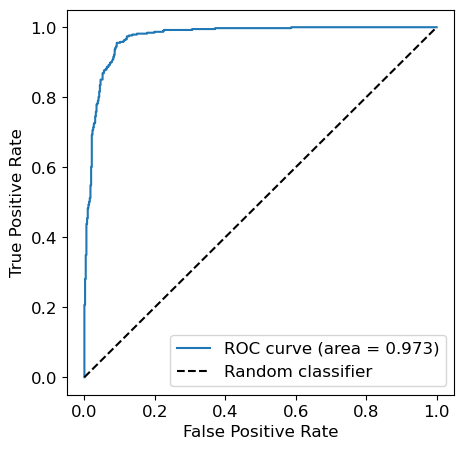

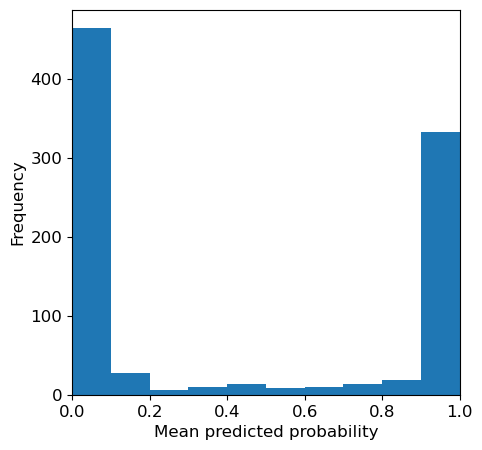

In [117]:
if OUTPUT != outputs.MultiOutput and METHOD != methods.SupportVector:
    # Compute the false positive rate (FPR) 
    # and true positive rate (TPR) for different classification thresholds
    if OUTPUT == outputs.MultiLabel:
        pos = 2
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,2], pos_label=pos)
    else:
        if METHOD == methods.XGBoost:
            pos = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=pos)
    fig = plt.figure(figsize=(5,5))
    ax1 = fig.add_subplot(111)
    # Plot the ROC curve 
    ax1.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc) 
    # roc curve for tpr = fpr  
    ax1.plot([0, 1], [0, 1], 'k--', label='Random classifier') 
    ax1.set_xlabel('False Positive Rate',fontsize=12) 
    ax1.set_ylabel('True Positive Rate',fontsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=12) 
    #ax1.set_title(f'ROC Curve') 
    ax1.legend(loc="lower right",fontsize=12) 
    plt.show()

    fig = plt.figure(figsize=(5,5))
    ax2 = fig.add_subplot(111)
    ax2.hist(y_pred_prob, bins=10) 
    ax2.set_xlim(0, 1) 
    #ax2.set_title(f'Predicted probabilities') 
    ax2.set_xlabel('Mean predicted probability',fontsize=12) 
    ax2.set_ylabel('Frequency',fontsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=12) 
    #fig.suptitle(TITLE)
    plt.show()

## Confusion Matrix

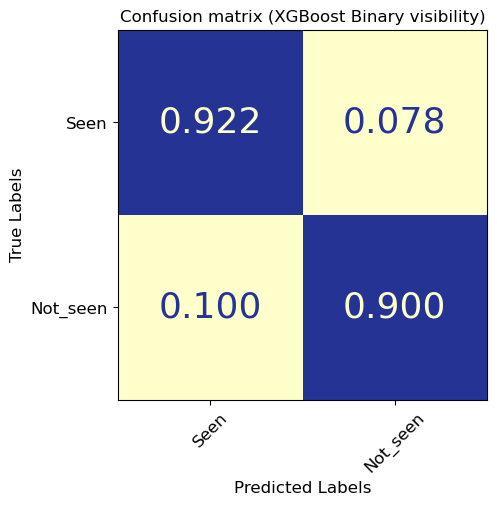

In [118]:
# plot your confusion matrix
if OUTPUT == outputs.MultiOutput:
    cm = confusion_matrix(get_easiest_method_names(y_test), get_easiest_method_names(y_predtest),normalize = 'true')
else:
    cm = confusion_matrix(y_test, y_predtest,normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ptype)

colours = ['#ffffcc','#a1dab4','#41b6c4','#2c7fb8','#253494']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colours, N=20)

disp.plot(xticks_rotation=45,cmap = custom_cmap,values_format=".3f",colorbar=False) #values_format=".1%")
for labels in disp.text_.ravel():
    if OUTPUT == outputs.MultiOutput:
        labels.set_fontsize(14)
    elif OUTPUT == outputs.MultiLabel:
        labels.set_fontsize(20)
    elif OUTPUT == outputs.Binary:
        labels.set_fontsize(26)
fig = disp.figure_
ax = disp.ax_
ax.set_xlabel('Predicted Labels',fontsize=12)
ax.set_ylabel('True Labels',fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
plt.title(f"Confusion matrix ({TITLE})")
plt.show()

## Importance Graph

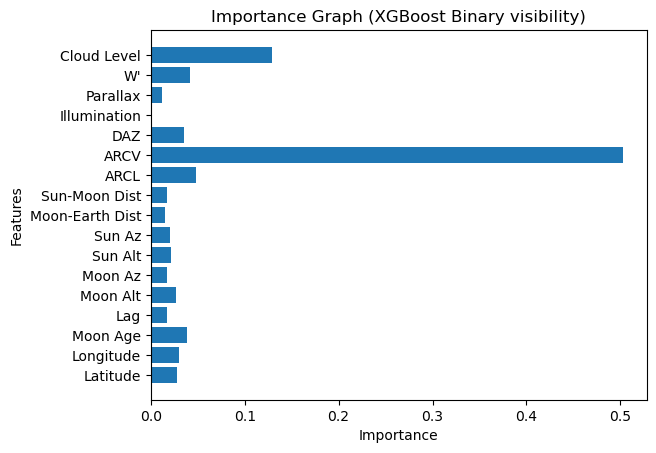

In [119]:
# Plot importance
if METHOD == methods.XGBoost or METHOD == methods.RandomForest:

    if METHOD != methods.XGBoost and OUTPUT == outputs.MultiOutput:
        feat_impts = [] 
        for clf in model.estimators_:
            feat_impts.append(clf.feature_importances_) 

        importance = np.mean(feat_impts, axis=0)

    else:
        importance = model.feature_importances_

    ytix = features
    plt.barh(range(len(features)), importance)
    plt.yticks(range(len(features)), features)
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title(f"Importance Graph ({TITLE})")
    plt.show()

## SHAP Analysis

In [120]:
if SHAP_ANALYSIS:
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X)
    plt.figure(figsize=(6,10))
    shap.summary_plot(shap_values, X, plot_type="bar",plot_size=[8,5],show=False)
    plt.ylabel("Features",fontsize=14)
    plt.xlabel("Mean Absolute SHAP Value",fontsize=14)
    #plt.title(f"Importance Graph ({TITLE})")
    plt.show()

In [121]:
if SHAP_ANALYSIS:
    shap.summary_plot(shap_values, X,plot_size=[8,7],show=False)
    plt.ylabel("Features")
    plt.title(f"Importance Graph ({TITLE})")
    plt.show()

## Generating contour map based on predictions - code

In [122]:
def contour_plot(lat_arr, lon_arr, qvals, labels,title,obs_date,labels_no):
    plt.figure(figsize=(9,5))

    x, y = np.meshgrid(lon_arr,lat_arr,indexing='xy')
    sqqvals = np.reshape(qvals,(len(lat_arr),len(lon_arr)))
    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    if labels_no == 2: #Binary
        all_colours = ['#ca0020','#0571b0']
        levels = [-0.5, 0.5, 1.5]
    elif labels_no == 3: #With aid
        all_colours = ['#ca0020','#f4a582','#0571b0']
        levels=[-0.5, 0.5, 1.5, 2.5]
    plt.contourf(x, y ,sqqvals,alpha=0.6, levels=levels,colors=all_colours)       
   
    nm = [plt.Rectangle((0, 0), 1, 1, color=color) for color in all_colours]
    leg = plt.legend(nm, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=labels_no)
    for lh in leg.legend_handles: 
        lh.set_alpha(0.6)
    if -np.min(lon_arr)+ np.max(lon_arr) ==360:
        plt.ylim(-90,90)
        plt.xlim(-180,180)
    else:
        ax.set_extent((np.min(lon_arr), np.max(lon_arr),np.min(lat_arr), np.max(lat_arr)),crs=ccrs.PlateCarree()) 

    title_date = obs_date.to_datetime().date()
    #plt.title(f"{title} Predicted New Crescent visibility at best time ({title_date})")
    plt.savefig(f"..\\Graphs\\Prediction Global moon visibility at best time ({title_date}).png",dpi=200)
    plt.show()


def yallop_to_scale(q_values,binary):
    quantified_q = np.empty((q_values.size),dtype=str)
    if binary:
        quantified_q[q_values > 0.216] = 1 #A Easily visible
        quantified_q[np.logical_and(0.216 >= q_values, q_values > -0.014)] = 1 #B Visible under perfect conditions
        quantified_q[np.logical_and(-0.014 >= q_values, q_values > -0.160)] = 1 #C May need optical aid to find crescent
        quantified_q[np.logical_and(-0.160 >= q_values, q_values > -0.232)] = 0 #D Will need optical aid to find crescent
        quantified_q[np.logical_and(-0.232 >= q_values, q_values > -0.293)] = 0 #E Not visible with a telescope ARCL ≤ 8·5°
        quantified_q[-0.293 >= q_values] = 0 #F Not visible, below Danjon limit, ARCL ≤ 8°
    else:
        quantified_q[q_values > 0.216] = 2 #A Easily visible
        quantified_q[np.logical_and(0.216 >= q_values, q_values > -0.014)] = 2 #B Visible under perfect conditions
        quantified_q[np.logical_and(-0.014 >= q_values, q_values > -0.160)] = 1 #C May need optical aid to find crescent
        quantified_q[np.logical_and(-0.160 >= q_values, q_values > -0.232)] = 1 #D Will need optical aid to find crescent
        quantified_q[np.logical_and(-0.232 >= q_values, q_values > -0.293)] = 0 #E Not visible with a telescope ARCL ≤ 8·5°
        quantified_q[-0.293 >= q_values] = 0 #F Not visible, below Danjon limit, ARCL ≤ 8°
    return quantified_q

def predict_contour_plot(obs_date,min_lat, max_lat, min_lon, max_lon, no_of_points):
    file_path = f'../Data/Generated/{obs_date.to_datetime().date()} LAT {min_lat} {max_lat} LON {min_lon} {max_lon} {no_of_points}x{no_of_points}'
    generated_params = pd.read_csv(file_path+'.csv')
    generated_params["Cloud Level"] = np.full(generated_params.shape[0],0)

    #Plots moon visibility across a world map
    lat_arr = np.linspace(min_lat, max_lat, no_of_points)
    lon_arr = np.linspace(min_lon, max_lon, no_of_points)

    #Get q-values and features from generated data
    yallop_qval = generated_params["q'"].to_numpy(dtype=float)
    generated_params = generated_params.drop(VARS_TO_DROP+["Seen","q'"], axis = 1)

    #Predict visibility using features
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80/20 training/test split
    model = select_model()
    model.fit(x_train, y_train)
    prediction = model.predict(generated_params).astype(int)
    #np.savetxt("test.csv", np.reshape(prediction,(len(lat_arr),len(lon_arr))).astype(int), delimiter=",")

    if OUTPUT == outputs.Binary:
        if METHOD != methods.XGBoost: #Non-xgboost predicts labels not numbers
            prediction[prediction=="Seen"] = 1
            prediction[prediction=="Not_seen"] = 0
            prediction = prediction.astype(int)
        #Convert yallop q-values into predictions
        yallop_prediction = yallop_to_scale(yallop_qval,True).astype(int)

        print(f"Y: Seen: {yallop_prediction[yallop_prediction==1].shape[0]} Not Seen: {yallop_prediction[yallop_prediction==0].shape[0]}")
        print(f"ML: Seen: {prediction[prediction==1].shape[0]} Not Seen: {prediction[prediction==0].shape[0]}")
        print(f"Accuracy (compared to Yallop q values): {accuracy_score(prediction,yallop_prediction):.1%}")
        contour_plot(lat_arr, lon_arr, prediction,["Not seen",'Seen'],METHOD.name,obs_date,2)
        contour_plot(lat_arr, lon_arr, yallop_prediction,["Not seen",'Seen'],"Yallop",obs_date,2)

    elif OUTPUT == outputs.MultiLabel:
        if METHOD != methods.XGBoost: #Non-xgboost predicts labels not numbers
            prediction[prediction=="Seen"] = 2
            prediction[prediction=="Seen_with_aid"] = 1
            prediction[prediction=="Not_seen"] = 0
            prediction = prediction.astype(int)
        yallop_prediction = yallop_to_scale(yallop_qval,False).astype(int)
        #np.savetxt("test2.csv", np.reshape(yallop_prediction,(len(lat_arr),len(lon_arr))).astype(int), delimiter=",")

        print(f"Y: Seen: {yallop_prediction[yallop_prediction==2].shape[0]} Aid: {yallop_prediction[yallop_prediction==1].shape[0]} Not Seen: {yallop_prediction[yallop_prediction==0].shape[0]}")
        print(f"ML: Seen: {prediction[prediction==2].shape[0]} Aid: {prediction[prediction==1].shape[0]} Not Seen: {prediction[prediction==0].shape[0]}")
        print(f"Accuracy (compared to Yallop q values): {accuracy_score(prediction,yallop_prediction):.1%}")
        contour_plot(lat_arr, lon_arr, prediction,["Not seen","Seen with aid",'Seen'],METHOD.name,obs_date,3)
        contour_plot(lat_arr, lon_arr, yallop_prediction,["Not seen","Seen with aid", 'Seen'],"Yallop",obs_date,3)

## Generating contour map based on predictions

In [123]:
if PREDICT_VISIBILITY:

    #Example
    #obs_date = Time("2023-03-22")
    #predict_contour_plot(obs_date,min_lat=-60, max_lat=60, min_lon=-180, max_lon=180, no_of_points=100)

    #October 2023 
    obs_date = Time("2023-10-15")
    predict_contour_plot(obs_date,min_lat=48, max_lat=60, min_lon=-8, max_lon=2, no_of_points=50)
    obs_date = Time("2023-10-16")
    predict_contour_plot(obs_date,min_lat=48, max_lat=60, min_lon=-8, max_lon=2, no_of_points=50)
    obs_date = Time("2023-10-17")
    predict_contour_plot(obs_date,min_lat=48, max_lat=60, min_lon=-8, max_lon=2, no_of_points=50)

    #November 2023 
    obs_date = Time("2023-11-14")
    predict_contour_plot(obs_date,min_lat=48, max_lat=60, min_lon=-8, max_lon=2, no_of_points=50)
    obs_date = Time("2023-11-15")
    predict_contour_plot(obs_date,min_lat=48, max_lat=60, min_lon=-8, max_lon=2, no_of_points=50)

    #December 2023 
    obs_date = Time("2023-12-14")
    #predict_contour_plot(obs_date,min_lat=48, max_lat=60, min_lon=-8, max_lon=2, no_of_points=50)
    predict_contour_plot(obs_date,min_lat=48, max_lat=58.5, min_lon=-8, max_lon=2, no_of_points=50)
    obs_date = Time("2023-12-15")
    predict_contour_plot(obs_date,min_lat=48, max_lat=60, min_lon=-8, max_lon=2, no_of_points=50)

## Comparing ML models

In [124]:
if COMPARE_METHODS:
    method_metrics = pd.DataFrame(columns=["Method", "Accuracy", "Accuracy std", "ROC","ROC std","Precision","Precision std","Recall","Recall std","F1","F1 std"])
    
    for method_type in methods:
        i = method_type.value
        if i <=7: #Ignore non-working models
            METHOD = method_type 
            model = select_model()
            metrics = traintestml(X,y, model)
            method_metrics.loc[i] = [method_type.name]+list(metrics)
            print(f"{method_type.name}: Test accuracy {metrics[0]:.3f}")

    print(method_metrics.head(10))
    #method_metrics.to_csv("method comparison.csv")

In [125]:
if COMPARE_METHODS:    
    fig, axes = plt.subplots(2,4, figsize=(12, 5))
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    for method_type in methods:
        i = method_type.value
        if i <=7: #Ignore non-working models
            METHOD = method_type
            model = select_model()
            if METHOD == methods.NearestNeighbours: # Bug with KNN requires numpy arrays
                model.fit(x_train.values, y_train)
                y_predtrain = model.predict(x_train.values)
                y_predtest = model.predict(x_test.values)
            else:
                model.fit(x_train, y_train)
                y_predtrain = model.predict(x_train)
                y_predtest = model.predict(x_test)
            # plot the accuracies of said predictions
            train_acc = accuracy_score(y_test, y_predtest)
            print(f"{method_type.name}: Test accuracy {accuracy_score(y_train, y_predtrain):.3f}. Train accuracy {train_acc:.3f}")

            if OUTPUT == outputs.MultiOutput:
                cm = confusion_matrix(get_easiest_method_names(y_test), get_easiest_method_names(y_predtest),normalize = 'true')
            else:
                cm = confusion_matrix(y_test, y_predtest,normalize = 'true')

            colours = ['#ffffcc','#a1dab4','#41b6c4','#2c7fb8','#253494']
            custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colours, N=20)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ptype)

            disp.plot(ax=axes.flatten()[i], xticks_rotation=45,cmap = custom_cmap,values_format=".3f",colorbar=False) #values_format=".1%")
            for labels in disp.text_.ravel():
                labels.set_fontsize(14)
            disp.ax_.set_title(f"{method_type.name}")
            disp.ax_.set_xlabel('')
            disp.ax_.set_ylabel('')
   
    fig.supxlabel("Predicted Labels",fontsize=14)
    fig.supylabel("True Labels",fontsize=14)
    plt.subplots_adjust(wspace=0.2, hspace=0.8)
    #fig.colorbar(disp.im_, ax=axes)
    plt.tight_layout()
    plt.show()

## Hyperparameter adjustment

In [126]:
if GRID_SEARCH and not (METHOD != methods.XGBoost and OUTPUT == outputs.MultiOutput):
    model = select_model()

    if METHOD == methods.XGBoost:
        test_params = {
            'max_depth': np.arange(2,10,2),
            'n_estimators': [10,25,30,50,100,200],
            'learning_rate': np.linspace(0.01,0.5,7)}
            #     'max_leaf_nodes': [2,5,10,20],
    else:

        test_params = {
            'max_depth': np.arange(2,16,1),
            'n_estimators': [10,25,30,50,100,150,200]}
            #'max_features': ['sqrt', 'log2', None]}
            # 'max_leaf_nodes': [2,5,10,20],
            # 'min_samples_leaf': [2,3, 5,10],
            # 'min_samples_split': [2,3,5,10]}

    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator=model,
        param_grid=test_params,
         verbose=2,n_jobs=-1,
          scoring="roc_auc")

    grid_search.fit(x_train, y_train)
    #print(grid_search.best_score_)
    model_best = grid_search.best_estimator_
    print(grid_search.best_params_) 

    # Produce predictions for the classification of your training dataset using your model:
    y_pred_best = model_best.predict(x_train)

    # plot the accuracies of said predictions
    model_best_acc_train = accuracy_score(y_train, y_pred_best)
    
    print(f"Accuracy on training dataset: {round(model_best_acc_train,5)}",)
    
    y_pred_best = model_best.predict(x_test)
    model_best_acc_test = accuracy_score(y_test, y_pred_best)
    print(f"Accuracy on testing dataset:{round(model_best_acc_test,5)}")
    